In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../data/raw/readmissions.csv')
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
print("rows: ", data.shape[0])
print("columns", data.shape[1])

rows:  101766
columns 50


In [4]:
print("atributes: ")
for column in data.columns:
    print(column)

atributes: 
encounter_id
patient_nbr
race
gender
age
weight
admission_type_id
discharge_disposition_id
admission_source_id
time_in_hospital
payer_code
medical_specialty
num_lab_procedures
num_procedures
num_medications
number_outpatient
number_emergency
number_inpatient
diag_1
diag_2
diag_3
number_diagnoses
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
insulin
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone
change
diabetesMed
readmitted


In [5]:
medications = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

print("number of medications: ", len(medications))

number of medications:  23


In [6]:
hospital_admissions = data["encounter_id"].nunique()
patients = data["patient_nbr"].nunique()
print("hospital admisions: ", hospital_admissions)
print("patients: ", patients)

hospital admisions:  101766
patients:  71518


## Preprocessing 

### Admission type

In [7]:
admission_type = pd.read_csv("../data/raw/admission_type.csv")
admission_type
admission_type.columns = ["admission_type_id", "admission_type"]

In [8]:
data = data.merge(admission_type, on='admission_type_id')

In [9]:
data["admission_type"].value_counts()

admission_type
Emergency        53990
Elective         18869
Urgent           18480
Trauma Center       21
Newborn             10
Name: count, dtype: int64

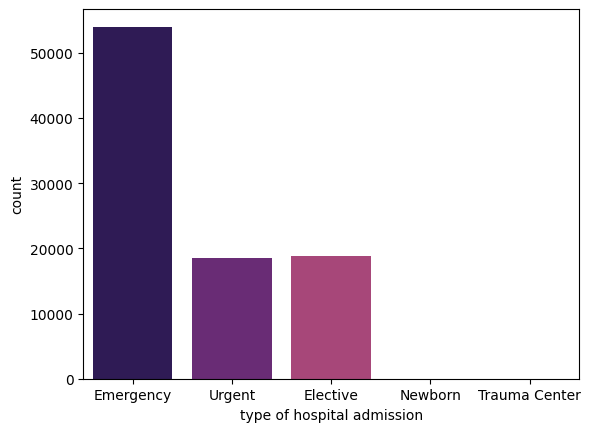

In [10]:
sns.countplot(x='admission_type', data=data, palette='magma')
plt.xlabel('type of hospital admission')
plt.show()

### Remove patients with discharg death (expired)

In [11]:

discharge_disposition = pd.read_csv("../data/raw/discharge_disposition.csv")

# get ids with discharg experied (death)
discharge_disposition['expired'] = discharge_disposition['description'].str.lower().str.contains('expired')
discharge_expired = discharge_disposition[discharge_disposition['expired']==True]
discharge_expired.head()

,discharge_disposition_id,description,expired
10,11,Expired,True
18,19,"Expired at home. Medicaid only, hospice.",True
19,20,"Expired in a medical facility. Medicaid only, ...",True
20,21,"Expired, place unknown. Medicaid only, hospice.",True


In [12]:
expired_ids = discharge_expired['discharge_disposition_id'].tolist()
print("discharge_disposition_id's that indicate an expired patient: ", expired_ids)

discharge_disposition_id's that indicate an expired patient:  [11, 19, 20, 21]


In [13]:
# remove all patiens with discharge result expired
data = data[data['discharge_disposition_id'].isin(expired_ids) == False]

In [14]:
patients_nonexpired = data['patient_nbr'].nunique()
print("number of patients before: ", patients)
print("number of patients after: ", patients_nonexpired)
print("number of patients with expired: ", patients - patients_nonexpired)

number of patients before:  71518
number of patients after:  70439
number of patients with expired:  1079


### Convert medicaments from categorical to boolean

In [15]:
for med in medications:
    print(data[med].value_counts())

metformin
No        80216
Steady    18256
Up         1067
Down        575
Name: count, dtype: int64
repaglinide
No        98587
Steady     1373
Up          109
Down         45
Name: count, dtype: int64
nateglinide
No        99419
Steady      660
Up           24
Down         11
Name: count, dtype: int64
chlorpropamide
No        100029
Steady        78
Up             6
Down           1
Name: count, dtype: int64
glimepiride
No        94967
Steady     4630
Up          324
Down        193
Name: count, dtype: int64
acetohexamide
No        100113
Steady         1
Name: count, dtype: int64
glipizide
No        87509
Steady    11284
Up          767
Down        554
Name: count, dtype: int64
glyburide
No        89547
Steady     9200
Up          806
Down        561
Name: count, dtype: int64
tolbutamide
No        100093
Steady        21
Name: count, dtype: int64
pioglitazone
No        92833
Steady     6934
Up          230
Down        117
Name: count, dtype: int64
rosiglitazone
No        93785
Steady

In [16]:
# change No to 0 and others to 1
# indicate if patient use medication
for m in medications:
    data[m] = np.where(data[m]=="No", 0, 1)


In [17]:
data[medications].head()

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# get medication prevalence in patients
prevalence = []

for m in medications:
    patient_meds = data.groupby('patient_nbr')[m].sum().reset_index()
    patient_meds[m] = patient_meds[m].astype(bool)
    n_patients_on_med = patient_meds[m].sum()
    proportion = n_patients_on_med / patients_nonexpired
    prevalence.append(proportion)

In [19]:
medication_counts = pd.DataFrame({'medication': medications, 'prevalence':prevalence})
medication_counts = medication_counts.sort_values(by='prevalence', ascending=False)
medication_counts.head()

,medication,prevalence
17,insulin,0.552109
0,metformin,0.233039
6,glipizide,0.141044
7,glyburide,0.120672
9,pioglitazone,0.083789


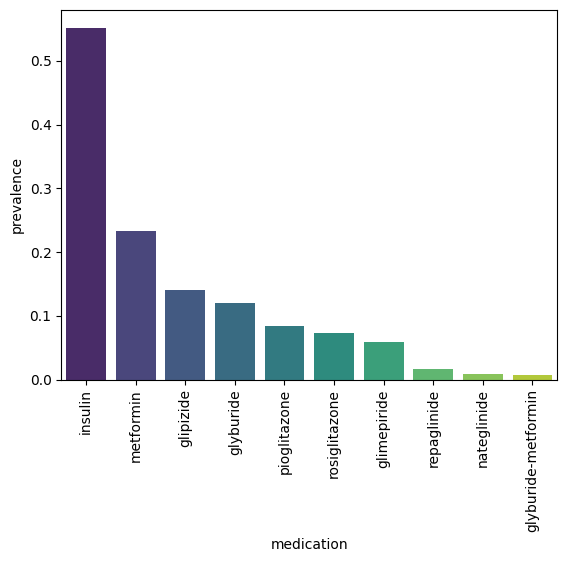

In [20]:
sns.barplot(x='medication', y='prevalence', data=medication_counts.head(10), palette='viridis')
plt.xticks(rotation=90)
plt.show()

### Create target readmission

In [21]:
data['readmitted'].value_counts()

readmitted
NO     53212
>30    35545
<30    11357
Name: count, dtype: int64

In [22]:
data["readmitted"] = np.where(data["readmitted"] == 'NO', 0, 1)
data["readmitted"].value_counts()

readmitted
0    53212
1    46902
Name: count, dtype: int64

### Missing values

In [23]:
missing_counts = data.isna().sum()
missing_counts_sorted = missing_counts.sort_values(ascending=False)
missing_counts_sorted

max_glu_serum               94890
A1Cresult                   83238
admission_type              10237
chlorpropamide                  0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
examide                         0
citoglipton                     0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
readmitted                      0
glimepiride                     0
encounter_id                    0
nateglinide                     0
patient_nbr                     0
race          

### Demografic and gender

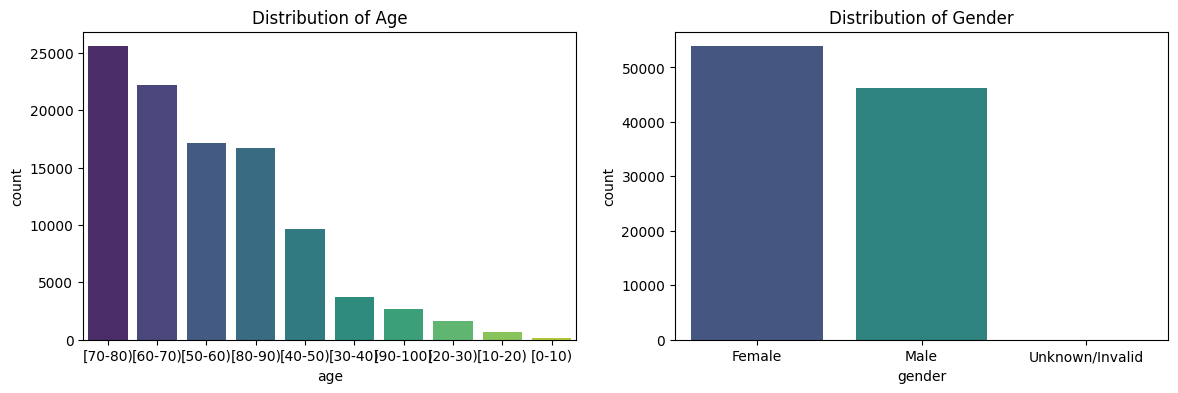

In [24]:
age_counts = data['age'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.countplot(x='age', data=data, palette='viridis', order=age_counts.index)
plt.title("Distribution of Age")

plt.subplot(1,2,2)
sns.countplot(x='gender', data=data, palette='viridis')
plt.title("Distribution of Gender")
plt.show()

In [25]:
data["gender"].value_counts()

gender
Female             53861
Male               46250
Unknown/Invalid        3
Name: count, dtype: int64

### Time stay

In [26]:
data["time_in_hospital"].value_counts()


time_in_hospital
3     17546
2     16976
1     13878
4     13775
5      9834
6      7425
7      5744
8      4323
9      2927
10     2290
11     1809
12     1401
13     1173
14     1013
Name: count, dtype: int64

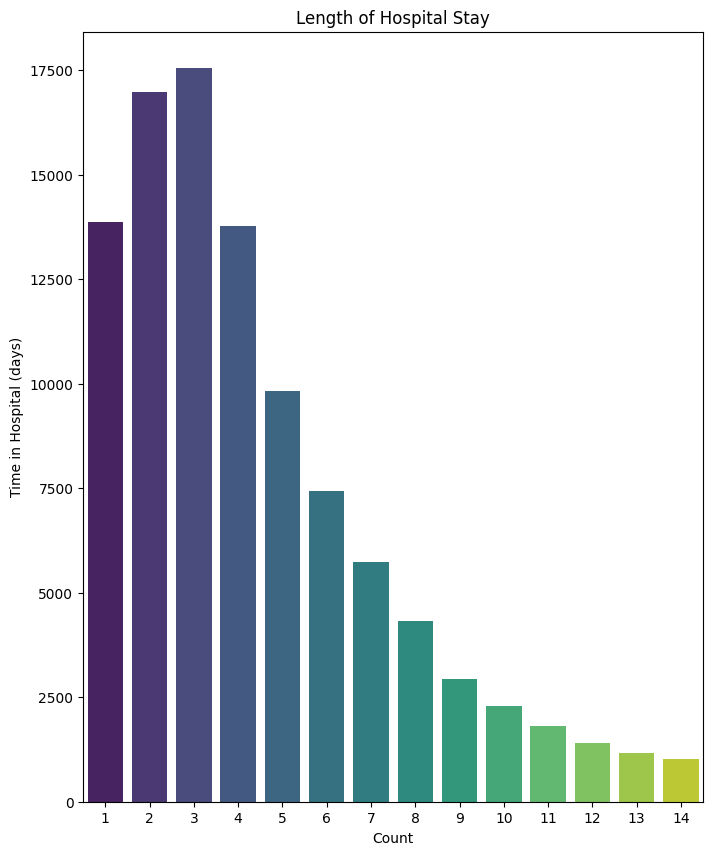

In [27]:
plt.figure(figsize=(8, 10))
sns.barplot(x=data['time_in_hospital'].value_counts().index, y=data['time_in_hospital'].value_counts(), palette='viridis')
plt.ylabel("Time in Hospital (days)")
plt.xlabel("Count")
plt.title("Length of Hospital Stay")
plt.show()

In [28]:
print(f"Mean time in hospital: {data['time_in_hospital'].mean():.2f}")

Mean time in hospital: 4.39


### Number of diagnoses, procedures and medications

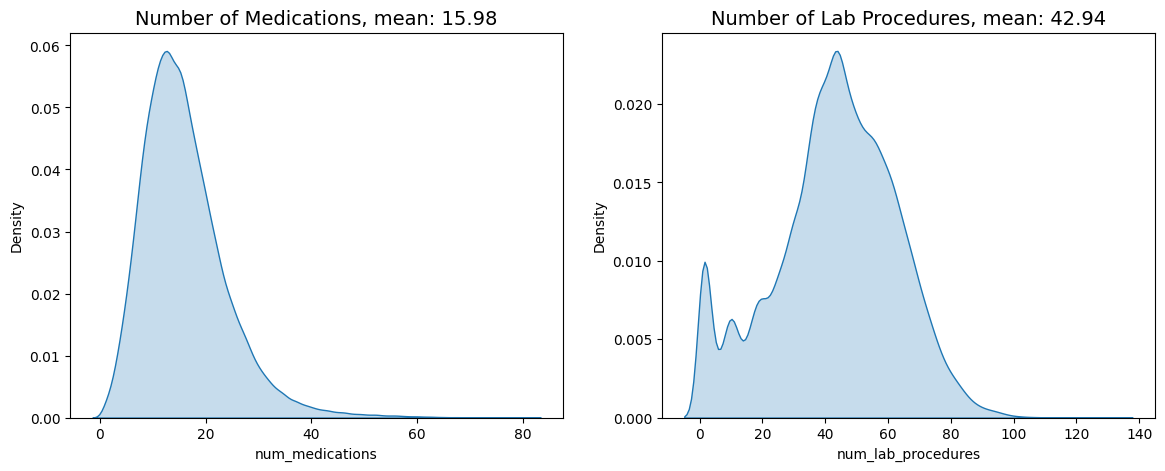

In [29]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.kdeplot(data['num_medications'], shade=True, legend=False)
plt.title(f"Number of Medications, mean: {data['num_medications'].mean():.2f}", size=14)

plt.subplot(1,2,2)
sns.kdeplot(data['num_lab_procedures'], shade=True, legend=False)
plt.title(f"Number of Lab Procedures, mean: {data['num_lab_procedures'].mean():.2f}", size=14)
plt.show()

### Medical speciality

In [30]:
medical_specialties = data['medical_specialty'].value_counts().reset_index()
medical_specialties.columns = ['specialty', 'count']
medical_specialties['prevalence'] = medical_specialties['count']/len(data)
print(f"There are {data['medical_specialty'].nunique()} medical specialties.")
medical_specialties.head(10)

There are 73 medical specialties.


,specialty,count,prevalence
0,?,49129,0.490731
1,InternalMedicine,14328,0.143117
2,Emergency/Trauma,7449,0.074405
3,Family/GeneralPractice,7302,0.072937
4,Cardiology,5296,0.052900
5,Surgery-General,3068,0.030645
6,Nephrology,1544,0.015422
7,Orthopedics,1394,0.013924
8,Orthopedics-Reconstructive,1231,0.012296
9,Radiologist,1129,0.011277


In [31]:
data["medical_specialty"].value_counts()

medical_specialty
?                                   49129
InternalMedicine                    14328
Emergency/Trauma                     7449
Family/GeneralPractice               7302
Cardiology                           5296
                                    ...  
SportsMedicine                          1
Speech                                  1
Surgery-PlasticwithinHeadandNeck        1
Perinatology                            1
Neurophysiology                         1
Name: count, Length: 73, dtype: int64

### Use medications during readmission

In [32]:
data['diabetesMed'].value_counts(normalize=True)

diabetesMed
Yes    0.77184
No     0.22816
Name: proportion, dtype: float64

### Classification diabetes

In [33]:
# no diabetes	            <5.7
# pre-diabetes	            5.7-6.4
# diabetes	                >6.5
# well-managed diabetes	    <7
# poorly managed diabetes	>8

data['A1Cresult'].value_counts(normalize=True)

A1Cresult
>8      0.482994
Norm    0.292783
>7      0.224224
Name: proportion, dtype: float64

In [34]:
print(f"Proportion of hospital admissions with missing A1C result: {data['A1Cresult'].isna().sum()/len(data):.2%}")

Proportion of hospital admissions with missing A1C result: 83.14%


### Preprocess categorical features

In [35]:
categorical = ['race', 'admission_type']

for c in categorical:
    data = pd.concat([data, pd.get_dummies(data[c], prefix=c)], axis=1)
    data.drop(columns=c)

In [36]:
data['age'].value_counts()

age
[70-80)     25562
[60-70)     22185
[50-60)     17102
[80-90)     16706
[40-50)      9626
[30-40)      3765
[90-100)     2668
[20-30)      1650
[10-20)       690
[0-10)        160
Name: count, dtype: int64

In [37]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

data['age'] = label_encoder.fit_transform(data['age'])
data['gender'] = label_encoder.fit_transform(data['gender'].astype(str))

In [38]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,admission_type_Elective,admission_type_Emergency,admission_type_Newborn,admission_type_Trauma Center,admission_type_Urgent
0,2278392,8222157,Caucasian,0,0,?,6,25,1,1,...,False,False,True,False,False,False,False,False,False,False
1,1968528,720936,Caucasian,0,7,?,6,25,1,10,...,False,False,True,False,False,False,False,False,False,False
2,2040360,661014,Caucasian,1,6,?,6,25,7,9,...,False,False,True,False,False,False,False,False,False,False
3,2088630,1719279,Caucasian,1,4,?,6,25,7,11,...,False,False,True,False,False,False,False,False,False,False
4,2091690,7919802,AfricanAmerican,0,4,?,6,25,7,6,...,True,False,False,False,False,False,False,False,False,False


### X and y

In [40]:
medications_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']

demographic_features = ['race_AfricanAmerican', 'race_Asian',
    'race_Caucasian', 'race_Hispanic', 'race_Other', 'age',
    'admission_type_Elective', 'admission_type_Newborn',
    'admission_type_Trauma Center', 'admission_type_Urgent', 'gender']

categorical_features = medications_features + demographic_features
data[categorical_features].head()

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,race_Asian,race_Caucasian,race_Hispanic,race_Other,age,admission_type_Elective,admission_type_Newborn,admission_type_Trauma Center,admission_type_Urgent,gender
0,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,0,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,7,False,False,False,False,0
2,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,6,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,True,False,False,4,False,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,4,False,False,False,False,0


In [42]:
continuous_features = ['num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']
data[continuous_features].head()

,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,41,0,1,0,0,0,1
1,56,2,24,0,0,0,9
2,61,4,25,0,0,0,9
3,68,0,25,0,0,0,9
4,47,2,13,0,0,0,8


In [44]:
all_features = categorical_features + continuous_features
data[all_features].head()

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,admission_type_Trauma Center,admission_type_Urgent,gender,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,0,0,0,0,0,0,0,0,0,0,...,False,False,0,41,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,False,False,0,56,2,24,0,0,0,9
2,0,0,0,0,0,0,0,0,0,0,...,False,False,1,61,4,25,0,0,0,9
3,0,0,0,0,0,0,0,0,0,0,...,False,False,1,68,0,25,0,0,0,9
4,0,0,0,0,0,0,0,0,0,0,...,False,False,0,47,2,13,0,0,0,8


In [45]:
X = data[all_features]
y = data['readmitted']

### Classification

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

search_space = {
    'n_estimators': [5,10,50],
    'max_depth': [3,5,10]
}

rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rfc, search_space, cv=3)
grid_search.fit(X, y)
print(f"Optimal hyperparameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.3f}")

Optimal hyperparameters: {'max_depth': 5, 'n_estimators': 50}
Best score: 0.617


In [47]:
results = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,3.243739,0.481045,0.273067,0.017852,5,50,"{'max_depth': 5, 'n_estimators': 50}",0.609014,0.633214,0.608373,0.616867,0.011562,1
2,2.399252,0.397764,0.182645,0.037509,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.600264,0.627461,0.613047,0.613591,0.011110,2
8,5.878449,1.370242,0.667045,0.021626,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.610332,0.621767,0.606814,0.612971,0.006383,3
4,0.684877,0.215709,0.080839,0.023564,5,10,"{'max_depth': 5, 'n_estimators': 10}",0.606107,0.624554,0.596686,0.609116,0.011574,4
7,0.632419,0.140991,0.056359,0.019467,10,10,"{'max_depth': 10, 'n_estimators': 10}",0.609553,0.614216,0.601510,0.608426,0.005248,5


In [48]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

search_space = {
    "n_estimators": randint(10,100),
    "max_depth": randint(1, 11)
}

random_search = RandomizedSearchCV(rfc, param_distributions=search_space, n_iter=9, cv=3)
random_search.fit(X,y)

print(f"Optimal hyperparameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_:.3f}")

Optimal hyperparameters: {'max_depth': 5, 'n_estimators': 67}
Best score: 0.616


In [49]:
results = pd.DataFrame(random_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,4.793576,0.828238,0.345930,0.165820,5,67,"{'max_depth': 5, 'n_estimators': 67}",0.608984,0.631746,0.608432,0.616387,0.010863,1
3,5.856068,0.413245,0.341821,0.057599,6,66,"{'max_depth': 6, 'n_estimators': 66}",0.609793,0.623565,0.609511,0.614290,0.006560,2
5,1.449389,0.108165,0.192659,0.049466,8,40,"{'max_depth': 8, 'n_estimators': 40}",0.609433,0.624584,0.606545,0.613521,0.007912,3
6,4.155527,0.203539,0.358417,0.134035,9,90,"{'max_depth': 9, 'n_estimators': 90}",0.610242,0.623595,0.606245,0.613361,0.007419,4
2,5.636379,1.605011,0.622807,0.045706,8,65,"{'max_depth': 8, 'n_estimators': 65}",0.610542,0.622786,0.606305,0.613211,0.006988,5


### Evaluating

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfc = RandomForestClassifier(**random_search.best_params_)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=67)

In [51]:
accuracy = rfc.score(X_test, y_test)

print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.620


In [52]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

y_pred = rfc.predict(X_test)

precision = precision_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Precision: 0.631
Recall: 0.470


Text(50.722222222222214, 0.5, 'actual')

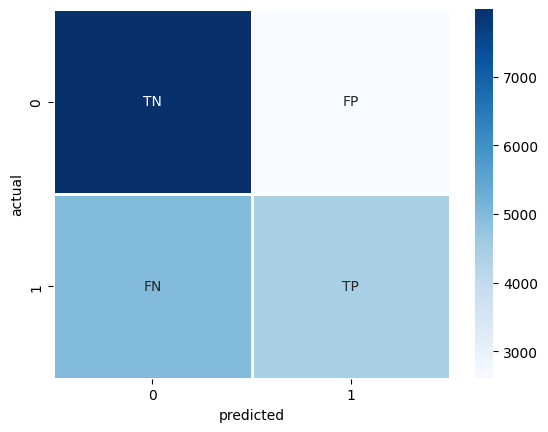

In [53]:
confusion = confusion_matrix(y_true=y_test, y_pred=y_pred)
labels = np.array([['TN','FP'],['FN','TP']])

sns.heatmap(confusion,annot=labels, fmt='', linewidths=2, cmap="Blues")
plt.xlabel("predicted")
plt.ylabel("actual")

In [54]:
feature_importances = {
    'features': list(X.columns.values),
    'importance': list(rfc.feature_importances_)
}

important_features = pd.DataFrame(feature_importances)
important_features.sort_values(by='importance', ascending=False).head(15)

,features,importance
39,number_inpatient,0.408380
38,number_emergency,0.183593
40,number_diagnoses,0.132540
37,number_outpatient,0.105177
36,num_medications,0.054548
28,age,0.023553
34,num_lab_procedures,0.020606
35,num_procedures,0.019004
29,admission_type_Elective,0.016917
17,insulin,0.009714


### Catboost

In [58]:
from catboost import CatBoostClassifier


cb_model = CatBoostClassifier(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='auc',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
)

clf.fit(X_train, y_train, 
        cat_features=categorical_features, 
        eval_set=(X_val, y_val), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1}


In [61]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    iterations=50,
    random_seed=42,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)

clf.fit(
    X_train, y_train,
    cat_features=categorical_features,
    eval_set=(X_val, y_val),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [92]:
# to do
# remove readmissions != emergence
# remove readmissions > 30
# remove readmissions when gender is Unknown/Invalid
# fill missing values
# missing values with ? 

In [ ]:
## 